In [1]:
# Dataset Used https://www.kaggle.com/datasets/issaisasank/guns-object-detection
import torch
import cv2
import numpy as np
import os
import enum
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
import time
import torch.optim
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2

In [2]:
BATCH_SIZE = 4
RESIZE_TO = 256
NUM_EPOCHS = 25  
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NUM_CLASSES = 2
IMAGES_PATH = "../input/guns-object-detection/Images"
LABELS_PATH = "../input/guns-object-detection/Labels"
OUT_DIR = "../outputs"
SAVE_PLOTS_EPOCH = 2  
SAVE_MODEL_EPOCH = 4

In [3]:
class Averager:
    def __init__(self):
        self.current_total= 0.0
        self.iterations = 0.0
        
    def send(self,value):
        self.current_total+=value
        self.iterations+=1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0* self.current_total/self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
    
def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():
    return A.Compose([
#         A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [4]:
images = os.listdir(IMAGES_PATH)
labels = os.listdir(LABELS_PATH)
ids,bboxes = [],[]
total_labels = len(labels)
for item in labels:
    with open(os.path.join(LABELS_PATH,item)) as f:
            lines = f.readlines()
            total_bbox = []
            ids.append(item.replace('.txt',''))
            for i in range(1,len(lines)):
                bbox_conversion = lines[i].replace('\n','').split(' ')
                for j in range(0,len(bbox_conversion)):
                    bbox_conversion[j] = int(bbox_conversion[j])
                total_bbox.append(bbox_conversion)
            bboxes.append(total_bbox)
train_ids = ids[:int(len(ids)*0.7)]
train_bboxes = bboxes[:int(len(bboxes)*0.7)]
test_ids = ids[int(len(ids)*0.7):]
test_bboxes = bboxes[int(len(bboxes)*0.7):]

In [5]:
class GunsDataset(Dataset):
    def __init__(self,size,train=True,transforms=None):
        self.transforms = transforms
        self.size = size
        if(train):
            self.ids = train_ids
            self.bboxes = train_bboxes
        else:
            self.ids = test_ids
            self.bboxes = test_bboxes
        
        
    def __getitem__(self,index):
        image_path = os.path.join(IMAGES_PATH,self.ids[index]+'.jpeg')
        image = cv2.imread(image_path)
        wt = image.shape[1]
        ht = image.shape[0]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.size, self.size))
        image_resized /= 255.0
        boxes = self.bboxes[index]
        boxes = np.array(boxes)
        mul = np.array([self.size/wt,self.size/ht,self.size/wt,self.size/ht])
        boxes = boxes*mul
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        labels = [1 for i in range(len(self.bboxes[index]))]
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        labels = torch.as_tensor(labels,dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target['area'] = torch.from_numpy(area)
#         target["image_id"] = int(self.ids[index])
        if self.transforms:
            sample = self.transforms(
                image=image_resized, bboxes=target["boxes"], labels=labels
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])
        return image_resized, target

    def __len__(self):
        return len(self.ids)

In [6]:
train_dataset = GunsDataset(
     RESIZE_TO,True, get_train_transform()
)
valid_dataset = GunsDataset(
     RESIZE_TO,True, get_valid_transform()
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    collate_fn=collate_fn,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    collate_fn=collate_fn,
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 233
Number of validation samples: 233



In [7]:
# img = cv2.imread('../input/guns-object-detection/Images/32.jpeg')
# plt
# total_bbox = []
# with open('../input/guns-object-detection/Labels/32.txt') as f:
#             lines = f.readlines()
#             ids.append(item.replace('.txt',''))
#             for i in range(1,len(lines)):
#                 bbox_conversion = lines[i].replace('\n','').split(' ')
#                 for j in range(0,len(bbox_conversion)):
#                     bbox_conversion[j] = int(bbox_conversion[j])
#                 total_bbox.append(bbox_conversion)
# boxes = np.array(total_bbox)
# area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
# print(area)
# for box in total_bbox:
#     cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,0,0),2)
# plt.imshow(img,cmap='gray')
# plt.grid(None) 

{'boxes': tensor([[ 64.2471, 202.1744, 145.2973, 240.2462]]), 'labels': tensor([1]), 'area': tensor([3085.7263], dtype=torch.float64)}


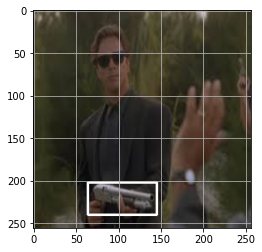

In [8]:
image, target = next(iter(train_loader))
image = image[0].permute(1,2,0).detach().cpu().numpy()
bboxes = target[0]['boxes'].numpy()
print(target[0])
for box in bboxes:
    box = box.astype(int)
    cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(100,100,100),2)
plt.imshow(image,cmap='gray')
plt.grid(None)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [11]:
plt.style.use("ggplot")


def train(train_data_loader, model):
    print("Training")
    global train_itr
    global train_loss_list
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list


def validate(valid_data_loader, model):
    print("validating")
    global val_itr
    global loss_list

    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)

        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return val_loss_list

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_loss_hist = Averager()
val_loss_hist = Averager()

train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

MODEL_NAME = "model"

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1} of {NUM_EPOCHS}")

    train_loss_hist.reset()
    val_loss_hist.reset()

    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch + 1) % SAVE_MODEL_EPOCH == 0:  # save model after every n epochs
        torch.save(model.state_dict(), f"model{epoch+1}.pth")
        print("SAVING MODEL COMPLETE...\n")

    if (epoch + 1) % SAVE_PLOTS_EPOCH == 0:  # save loss plots after n epochs
        train_ax.plot(train_loss, color="blue")
        train_ax.set_xlabel("iterations")
        train_ax.set_ylabel("train loss")
        valid_ax.plot(val_loss, color="red")
        valid_ax.set_xlabel("iterations")
        valid_ax.set_ylabel("validation loss")
        figure_1.savefig(f"train_loss_{epoch+1}.png")
        figure_2.savefig(f"valid_loss_{epoch+1}.png")
        print("SAVING PLOTS COMPLETE...")

    if (epoch + 1) == NUM_EPOCHS:  # save loss plots and model once at the end
        train_ax.plot(train_loss, color="blue")
        train_ax.set_xlabel("iterations")
        train_ax.set_ylabel("train loss")
        valid_ax.plot(val_loss, color="red")
        valid_ax.set_xlabel("iterations")
        valid_ax.set_ylabel("validation loss")
        figure_1.savefig(f"train_loss_{epoch+1}.png")
        figure_2.savefig(f"valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"model{epoch+1}.pth")

    plt.close("all")
    # sleep for 5 seconds after each epoch
    time.sleep(5)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]


Epoch 1 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #0 train loss: 0.336
Epoch #0 validation loss: 0.242
Took 0.700 minutes for epoch 0

Epoch 2 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #1 train loss: 0.219
Epoch #1 validation loss: 0.186
Took 0.595 minutes for epoch 1
SAVING PLOTS COMPLETE...

Epoch 3 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #2 train loss: 0.173
Epoch #2 validation loss: 0.152
Took 0.595 minutes for epoch 2

Epoch 4 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #3 train loss: 0.147
Epoch #3 validation loss: 0.132
Took 0.596 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 5 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #4 train loss: 0.127
Epoch #4 validation loss: 0.112
Took 0.596 minutes for epoch 4

Epoch 6 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #5 train loss: 0.111
Epoch #5 validation loss: 0.098
Took 0.598 minutes for epoch 5
SAVING PLOTS COMPLETE...

Epoch 7 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #6 train loss: 0.098
Epoch #6 validation loss: 0.097
Took 0.600 minutes for epoch 6

Epoch 8 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #7 train loss: 0.093
Epoch #7 validation loss: 0.081
Took 0.598 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 9 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #8 train loss: 0.082
Epoch #8 validation loss: 0.074
Took 0.595 minutes for epoch 8

Epoch 10 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #9 train loss: 0.074
Epoch #9 validation loss: 0.070
Took 0.598 minutes for epoch 9
SAVING PLOTS COMPLETE...

Epoch 11 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #10 train loss: 0.069
Epoch #10 validation loss: 0.064
Took 0.598 minutes for epoch 10

Epoch 12 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #11 train loss: 0.066
Epoch #11 validation loss: 0.060
Took 0.597 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 13 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #12 train loss: 0.062
Epoch #12 validation loss: 0.058
Took 0.596 minutes for epoch 12

Epoch 14 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #13 train loss: 0.058
Epoch #13 validation loss: 0.053
Took 0.599 minutes for epoch 13
SAVING PLOTS COMPLETE...

Epoch 15 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #14 train loss: 0.055
Epoch #14 validation loss: 0.052
Took 0.597 minutes for epoch 14

Epoch 16 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #15 train loss: 0.054
Epoch #15 validation loss: 0.057
Took 0.596 minutes for epoch 15
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 17 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #16 train loss: 0.058
Epoch #16 validation loss: 0.054
Took 0.597 minutes for epoch 16

Epoch 18 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #17 train loss: 0.054
Epoch #17 validation loss: 0.049
Took 0.597 minutes for epoch 17
SAVING PLOTS COMPLETE...

Epoch 19 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #18 train loss: 0.049
Epoch #18 validation loss: 0.046
Took 0.597 minutes for epoch 18

Epoch 20 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #19 train loss: 0.046
Epoch #19 validation loss: 0.042
Took 0.595 minutes for epoch 19
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 21 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #20 train loss: 0.046
Epoch #20 validation loss: 0.044
Took 0.595 minutes for epoch 20

Epoch 22 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #21 train loss: 0.042
Epoch #21 validation loss: 0.039
Took 0.596 minutes for epoch 21
SAVING PLOTS COMPLETE...

Epoch 23 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #22 train loss: 0.042
Epoch #22 validation loss: 0.044
Took 0.597 minutes for epoch 22

Epoch 24 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #23 train loss: 0.042
Epoch #23 validation loss: 0.040
Took 0.596 minutes for epoch 23
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

Epoch 25 of 25
Training


  0%|          | 0/58 [00:00<?, ?it/s]

validating


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch #24 train loss: 0.042
Epoch #24 validation loss: 0.039
Took 0.597 minutes for epoch 24


[ 16  72 166 157]


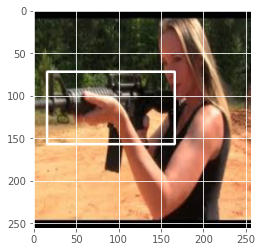

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(num_classes=2).to(device)
model.load_state_dict(torch.load(
    './model25.pth', map_location=device
))
model.eval()

images,targets = next(iter(valid_loader))
images = list(image.to(DEVICE) for image in images)
targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
a = model(images)
img = images[0].permute(1,2,0).detach().cpu().numpy()
boxes = targets[0]['boxes'].detach().cpu().numpy()
for box in boxes:
    box = box.astype(int)
    print(box)
    cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(100,100,100),2)
plt.imshow(img,cmap='gray')